In [43]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /opt/conda/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /opt/conda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /opt/conda/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /opt/conda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /opt/conda/nltk_data...


True

In [2]:
colour_dict = {
    "Liberal": "red",
    "Conservative": "blue",
    "New Democratic Party": "orange",
    "Green Party": "green",
    "Bloc Québécois": "teal",
    "Independent": "grey",
    "People's Party": "purple"
}

In [3]:
df_lst = []
file_path = os.getcwd() + "/May 2019/"

file_list = pd.to_datetime(pd.Series(os.listdir(file_path)).str[:-4]).dt.date.sort_values().reset_index(drop=True)

for f in file_list:
    df_lst += [pd.read_csv(file_path + f.strftime("%-Y-%-m-%-d") + '.csv')]

In [4]:
df_lst[0].columns

Index(['basepk', 'hid', 'speechdate', 'pid', 'opid', 'speakeroldname',
       'speakerposition', 'maintopic', 'subtopic', 'subsubtopic', 'speechtext',
       'speakerparty', 'speakerriding', 'speakername', 'speakerurl'],
      dtype='object')

In [5]:
full_df = pd.concat(df_lst)

# General Measures

In [6]:
topics_by_day = []
for day in df_lst:
    topics_by_day += [(day["maintopic"].str.title()).value_counts()]
    
all_topics = pd.concat(topics_by_day).index.unique()

In [7]:
topic_dict = {}
for topic in all_topics:
    topic_dict[topic] = []
    for day in range(len(topics_by_day)):
        if topic.title() in topics_by_day[day].keys():
            topic_dict[topic.title()] += [topics_by_day[day][topic]]
        else:
            topic_dict[topic.title()] += [0]

<b><u>Figure 1: Number of Speeches by Topic in  May 2019</u></b>:
>On most days, there were approximatly 100 speeches concerning Government Orders and Oral Questions, with most other topics hovering at approximatly 10 speeches per day. On May 15th (and to a lesser extent May 28th), there was a large increase in the number of speeches concerning Government Orders.

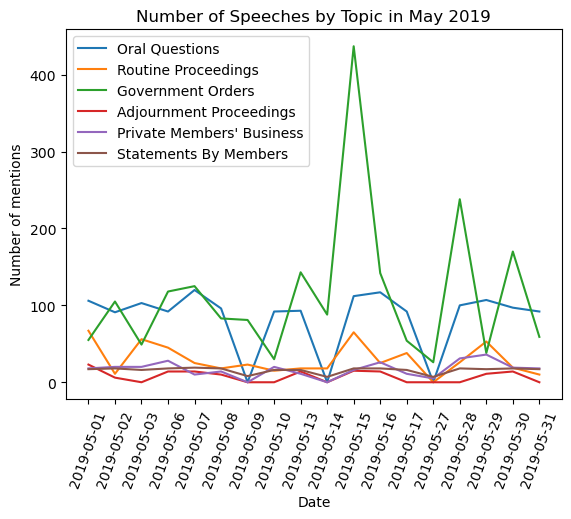

In [8]:
for topic in all_topics:
    plt.plot(topic_dict[topic])
    plt.title("Number of Speeches by Topic in May 2019")
    
plt.ylabel("Number of mentions")
plt.xlabel("Date")
plt.xticks(ticks=range(len(file_list)), labels=file_list, rotation=70)
plt.legend(all_topics)
plt.show()

In [9]:
party_by_day = []
for day in df_lst:
    party_by_day += [(day["speakerparty"].str.title()).value_counts()]
    
all_parties = pd.concat(party_by_day).index.unique()

In [10]:
party_dict = {}

for party in all_parties:
    party_dict[party] = []
    for day in range(len(party_by_day)):
        if party.title() in party_by_day[day].keys():
            party_dict[party.title()] += [party_by_day[day][party]]
        else:
            party_dict[party.title()] += [0]

<b><u>Figure 2: Number of Speeches From Each Party in May 2019</u></b>:
>The number of speeches from each party coincides generally with the number of MPs associated with those parties, with Liberal MPs making the most speeches followed by Conservative and NPD MPs.

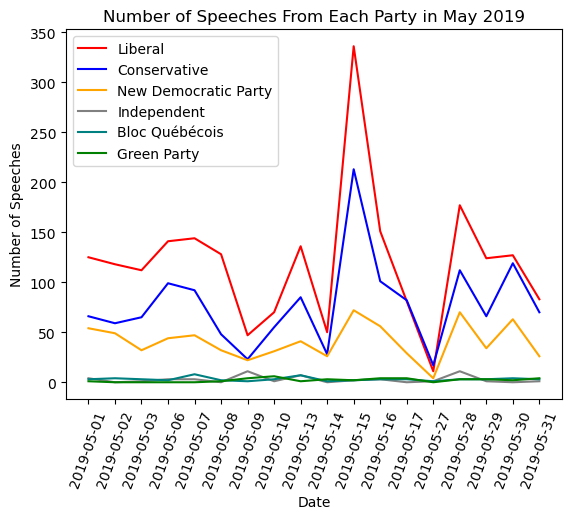

In [11]:
for party in all_parties:
    colour = colour_dict[party] if party in colour_dict.keys() else None
    plt.plot(party_dict[party], color=colour)
    plt.title(f"Number of Speeches From Each Party in May 2019")
    
plt.ylabel("Number of Speeches")
plt.xlabel("Date")
plt.xticks(ticks=range(len(file_list)), labels=file_list, rotation=70)
plt.legend(all_parties)
plt.show()

In [151]:
mp_df = pd.read_csv("mps.csv")
mp_df = mp_df.replace("NDP", "New Democratic Party")

num_mps_by_party = mp_df["Political Affiliation"].value_counts()
total_num_mps = np.sum(num_mps_by_party)

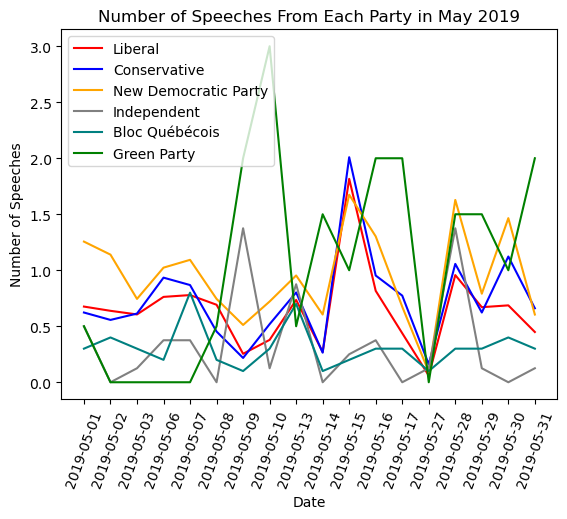

In [13]:
for party in all_parties:
    colour = colour_dict[party] if party in colour_dict.keys() else None
    plt.plot(party_dict[party]/num_mps_by_party[party], color=colour)
    plt.title(f"Number of Speeches From Each Party in May 2019")
    
plt.ylabel("Number of Speeches")
plt.xlabel("Date")
plt.xticks(ticks=range(len(file_list)), labels=file_list, rotation=70)
plt.legend(all_parties)
plt.show()

<b><u>Figure 3: Number of MPs by Party in May 2019</u></b>:
>As can be seen, the largest parties are the Liberal Party (which has a majority government), followed by the Conservative Party and New Democratic Party. These three form the largest Centrist, Right- and Left-wing parties in Canada.

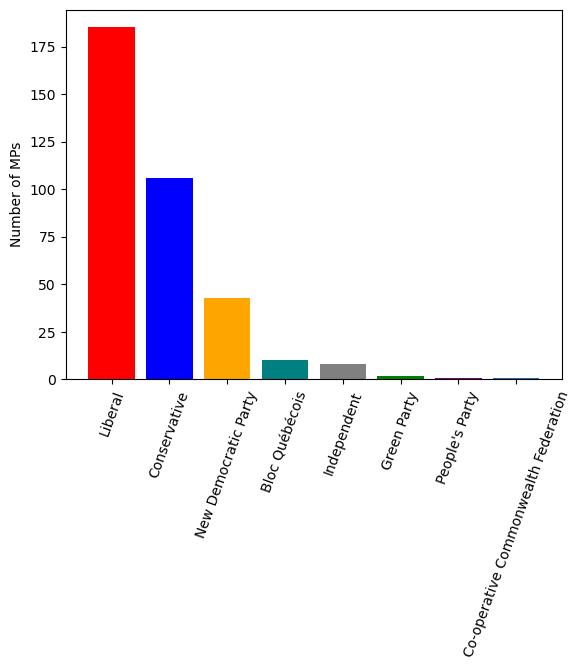

In [14]:
party_names = num_mps_by_party.index
for party in party_names:
    colour = colour_dict[party] if party in colour_dict.keys() else None
    plt.bar(party, num_mps_by_party[party], color=colour)

plt.ylabel("Number of MPs")
plt.xticks(ticks=range(len(party_names)), labels=party_names, rotation=70)
plt.show()

In [15]:
pd.DataFrame(num_mps_by_party).T

,Liberal,Conservative,New Democratic Party,Bloc Québécois,Independent,Green Party,People's Party,Co-operative Commonwealth Federation
Political Affiliation,185,106,43,10,8,2,1,1


<b><u>Table 1: Number of MPs by Party in May 2019</u></b>

# Analysis of Speakers and Speeches

In [16]:
speeches_by_party = pd.concat(df_lst)[["speakerparty", "speakername"]]

In [17]:
speakers_by_party = []
for party in all_parties:
    speakers_by_party += [
        pd.DataFrame({party :speeches_by_party[speeches_by_party["speakerparty"] == party]["speakername"].value_counts().head()})
    ]

In [18]:
speakers_by_party_df_list = []
for df in speakers_by_party:
    party = df.columns[0]
    df = df.reset_index()
    df.columns = [(party, "Speaker"), (party, "Num Speeches")]
    tuples = df.transpose().index
    new_columns = pd.MultiIndex.from_tuples(tuples, names=[' ', ' '])
    df.columns = new_columns
    speakers_by_party_df_list += [df]
    
speakers_by_party_df = pd.concat(speakers_by_party_df_list, axis=1).fillna("")
speakers_by_party_df

Liberal                 Conservative               \
            Speaker Num Speeches         Speaker Num Speeches   
0       Geoff Regan          260   Bruce Stanton          122   
1  Harjit S. Sajjan          171  Cheryl Gallant           55   
2   Kevin Lamoureux          168     James Bezan           48   
3      Anthony Rota          130  Leona Alleslev           47   
4    Justin Trudeau          100  Kelly McCauley           47   

   New Democratic Party                           Independent               \
                Speaker Num Speeches                  Speaker Num Speeches   
0          Carol Hughes          128  Celina Caesar-Chavannes           13   
1          Peter Julian           48            Hunter Tootoo           11   
2         Jagmeet Singh           34                Erin Weir           11   
3         Rachel Blaney           28            Jane Philpott            5   
4  Pierre-Luc Dusseault           27       Darshan Singh Kang            4   

      Bloc Québécois                 Green Party               
             Speaker Num Speeches        Speaker Num Speeches  
0      Monique Pauzé           13  Elizabeth May         36.0  
1    Michel Boudrias            8     Paul Manly          2.0  
2      Luc Thériault            7                              
3      Marilène Gill            7                              
4  Gabriel Ste-Marie            5

<b><u>Table 2: Top 5 Most Prolific Speakers By Party in May 2019</u></b>:
>It can be seen above that most speeches are performed by the "top 3" parties: the Liberals, Conservatives and the NDP. As Geoff Regan was Speaker of the House at this time, he delivered by far the most speeches. As the Liberals were the largest party in the House at this time, they made the most speeches.

In [19]:
positions = pd.read_csv('house-officers-42.csv')

In [20]:
mp_plus_title = pd.DataFrame(positions["Title"])
mp_plus_title["Name"] = positions["First Name"] + " " + positions["Last Name"]

## Basic Language Analysis

In [21]:
def clean_str(string):
    clean_str_1 =  re.sub(r'[^\w] ', ' ', string)
    clean_str_2 = re.sub(r'\n', '', clean_str_1)
    clean_str_3 = clean_str_2.replace('\\', '')
    clean_str_4 = re.sub(r'\.', ' ', clean_str_3)
    return clean_str_4

In [44]:
stop_words = set(stopwords.words('english'))
stop_words.add("government")
stop_words.add("party")
stop_words.add("speaker")
stop_words.add("canada")
stop_words.add("canadian")
stop_words.add("member")
stop_words.add("would")
stop_words.add("bill")
stop_words.add("mr")

In [76]:
speeches_by_party = full_df[["speakerparty", "speechtext"]]
combined_speeches = {}
combined_speeches_top_words = []
st = nltk.stem.SnowballStemmer(language='english', ignore_stopwords=False)

for party in all_parties:
    party_speeches = speeches_by_party[speeches_by_party["speakerparty"] == party]["speechtext"]
    party_str = (' '.join(party_speeches)).lower()
    party_str_clean = clean_str(party_str)
    combined_speeches[party] = party_str_clean

for party in combined_speeches.keys():
    combined_speech = ' '.join([st.stem(word) for word in combined_speeches[party].split()])
    most_common = pd.Series(combined_speech.split()).value_counts()
    combined_speeches_top_words += [pd.DataFrame({
        party: most_common[~most_common.index.isin(set(stop_words))].head(10)
    })]

In [77]:
words_by_party_df_list = []
for df in combined_speeches_top_words:
    party = df.columns[0]
    df = df.reset_index()
    df.columns = [(party, "Word"), (party, "Num Appearances")]
    tuples = df.transpose().index
    new_columns = pd.MultiIndex.from_tuples(tuples, names=[' ', ' '])
    df.columns = new_columns
    words_by_party_df_list += [df]
    
top_words_by_party_df = pd.concat(words_by_party_df_list, axis=1).fillna("")
top_words_by_party_df

Liberal                 Conservative                  \
        Word Num Appearances         Word Num Appearances   
0     govern            1819       govern            2302   
1       work            1355       minist            1736   
2      peopl            1063        liber            1506   
3       hous             980        peopl            1094   
4       year             889        prime            1062   
5    conserv             885          tax             989   
6  communiti             823           go             901   
7     import             817          one             827   
8       make             804         time             803   
9        one             800         hous             720   

  New Democratic Party                 Independent                  \
                  Word Num Appearances        Word Num Appearances   
0               govern            1324      govern              93   
1                peopl             775      legisl              71   
2                liber             770       peopl              69   
3                 need             449     languag              67   
4                 time             422        want              57   
5                 year             417     indigen              56   
6                 want             414   communiti              48   
7                 hous             414    question              46   
8                  one             409         one              41   
9                 work             378        hous              41   

  Bloc Québécois                 Green Party                  
            Word Num Appearances        Word Num Appearances  
0         quebec             142      govern              30  
1        languag              97        time              25  
2         french              88       place              24  
3         govern              73         say              23  
4        english              34       peopl              23  
5           want              33         hon              22  
6          peopl              32         use              21  
7         offici              32      minist              19  
8           year              30     countri              19  
9           make              26        veri              18

<b><u>Table 3: Top 10 Most Commonly Used Words by Party:</u></b>:
>It can be seen above that the majority of commonly used words (with stopwords removed) are standard words that do not provide much insight into the policies of the parties. Further analysis is needed where these words are removed.

## Vader Score Analysis of Speeches

In [24]:
def evalSpeech(speech_df):
    sid = SentimentIntensityAnalyzer()
    score_df = pd.DataFrame(columns=["speechID", "speakerName", "party", "speechText", "compound_score", "full_scores"])

    for idx, speech in speech_df.iterrows():
        ss = sid.polarity_scores(speech["speechtext"])
        score_df.loc[idx] = [speech["basepk"], speech["speakername"], speech["speakerparty"], speech["speechtext"], ss["compound"], ss]

    return score_df

In [25]:
vader_speeches = evalSpeech(full_df).dropna()

<b><u>Figure 4: Average Compound Vader Scores of Speeches by Party in May 2019</u></b>:
>The Liberal Party and New Democratic Party members are seen to make generally more positive speeches than either the Conservatives or Bloc Quebecios. As this was a Liberal majority government, this makes sense - the Liberals are in power and the NDP hold similar views to them. The Conservative Party, being the official opposition party, held far more negative speeches. The Bloc Quebecois, a Quebec nationalist/sovereignist party, held significantly more negative speeches than other parties.

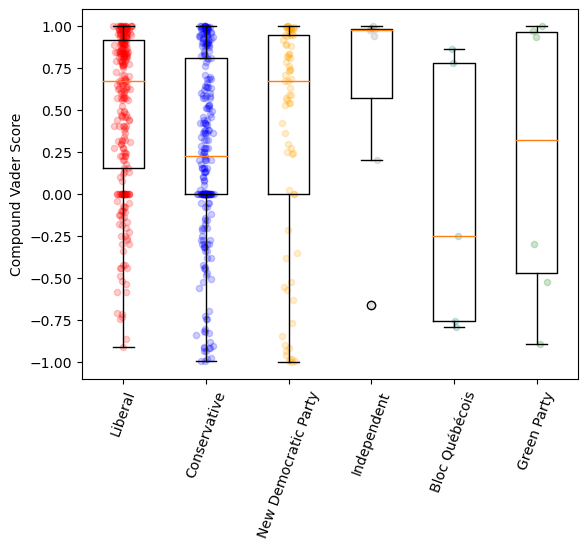

In [26]:
party_compound_vader = []
for party in all_parties:
    party_compound_vader += [vader_speeches[vader_speeches["party"] == party]["compound_score"].rename(party)]
    
plt.boxplot(party_compound_vader)  

for i, d in enumerate(party_compound_vader):
    colour = colour_dict[d.name] if party in colour_dict.keys() else None
    x = np.random.normal(i + 1, 0.04, len(d))
    plt.scatter(x, d, alpha=0.2, s=20, color=colour)

plt.xticks(range(1, len(all_parties) + 1), all_parties, rotation=70)
plt.ylabel("Compound Vader Score")
plt.show()

In [27]:
overall_scores = {}
for party in all_parties:
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(combined_speeches[party])
    overall_scores[party] = ss

In [28]:
pd.DataFrame(overall_scores)

,Liberal,Conservative,New Democratic Party,Independent,Bloc Québécois,Green Party
neg,0.050,0.072,0.082,0.033,0.0630,0.061
neu,0.788,0.807,0.793,0.822,0.8320,0.793
pos,0.162,0.122,0.125,0.145,0.1050,0.146
compound,1.000,1.000,1.000,1.000,0.9999,1.000


<b><u>Table 4: Vader Sentiment of Combined May 2019 Speeches:</u></b>:
>As seem above, most parties are quite neutral overall in their speeches, with Conservative MPs being the most negative and Liberal MPs being the most positive. Compound scores, being approximatly equal to 1 in all cases, does not provide any usable information.

<b><u>Figure 5: Vader Scores of Speeches by Party in May 2019</u></b>:
>Here we can see the boxplots of vader scores for each party. This shows a better representation of the overall emotion of each party's speeches, and how individual speeches were inside or outside of the norm for those parties.

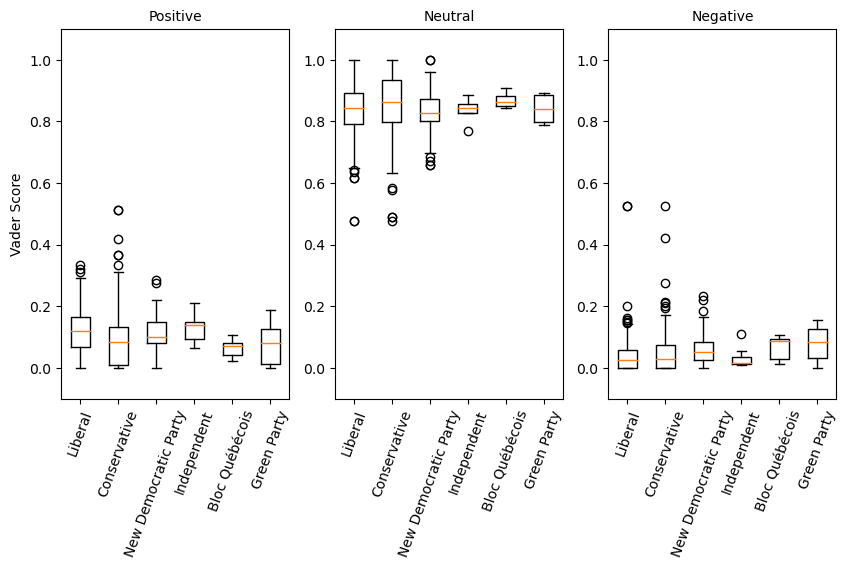

In [29]:
party_pos_vader = []
party_neu_vader = []
party_neg_vader = []

for party in all_parties:
    party_pos_vader += [vader_speeches[vader_speeches["party"] == party]["full_scores"].str["pos"]]
    party_neu_vader += [vader_speeches[vader_speeches["party"] == party]["full_scores"].str["neu"]]
    party_neg_vader += [vader_speeches[vader_speeches["party"] == party]["full_scores"].str["neg"]]
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True)
    
ax1.boxplot(party_pos_vader)
ax2.boxplot(party_neu_vader)
ax3.boxplot(party_neg_vader)

ax1.set_xticks(range(1, len(all_parties) + 1), all_parties, rotation=70)
ax2.set_xticks(range(1, len(all_parties) + 1), all_parties, rotation=70)
ax3.set_xticks(range(1, len(all_parties) + 1), all_parties, rotation=70)

ax1.set_ylim([-0.1, 1.1])
ax2.set_ylim([-0.1, 1.1])
ax3.set_ylim([-0.1, 1.1])

ax1.set_ylabel("Vader Score")
ax1.set_title("Positive", fontsize=10)
ax2.set_title("Neutral", fontsize=10)
ax3.set_title("Negative", fontsize=10)
#fig.suptitle("Vader Scores of Speeches by Party", fontsize=14)

fig.set_figwidth(10)

plt.show()

# New Stuff

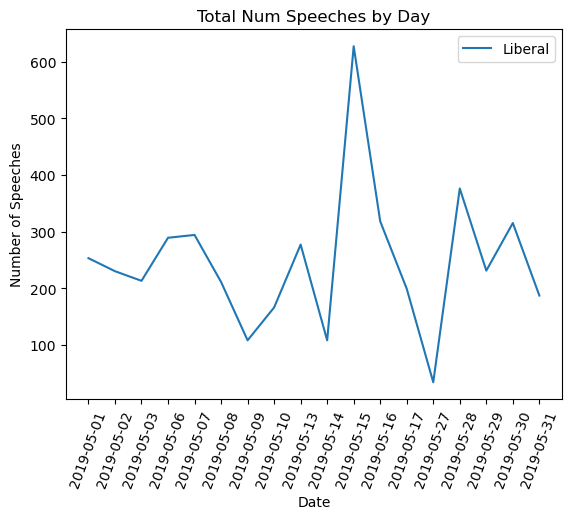

In [98]:
plt.title("Total Num Speeches by Day")
plt.plot(np.sum(list(party_dict.values()), axis=0))
plt.ylabel("Number of Speeches")
plt.xlabel("Date")
plt.xticks(ticks=range(len(file_list)), labels=file_list, rotation=70)
plt.legend(all_parties)
plt.show()

In [118]:
unique_speakers = []
for day in df_lst:
    unique_date = day["pid"].unique()
    unique_date = unique_date[~pd.isnull(unique_date)]
    unique_speakers += [len(unique_date)]

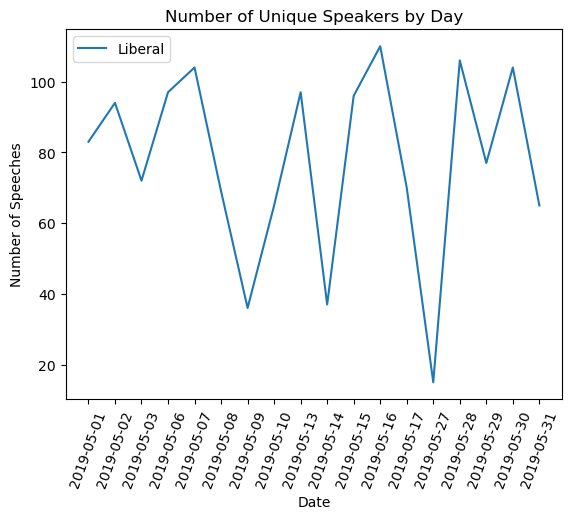

In [120]:
plt.title("Number of Unique Speakers by Day")
plt.plot(unique_speakers)
plt.ylabel("Number of Speeches")
plt.xlabel("Date")
plt.xticks(ticks=range(len(file_list)), labels=file_list, rotation=70)
plt.legend(all_parties)
plt.show()

In [128]:
unique_party_by_day = {}
for party in all_parties:
    unique_party_by_day[party] = []

for day in df_lst:
    for party in all_parties:
        p_day = day[day["speakerparty"] == party]
        
        unique_date = p_day["pid"].unique()
        unique_date = unique_date[~pd.isnull(unique_date)]
        unique_party_by_day[party] += [len(unique_date)]

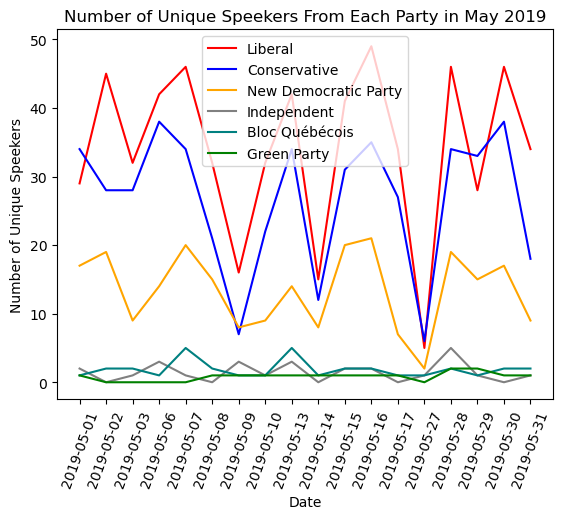

In [131]:
for party in all_parties:
    colour = colour_dict[party] if party in colour_dict.keys() else None
    plt.plot(unique_party_by_day[party], color=colour)
    plt.title("Number of Unique Speekers From Each Party in May 2019")
    
plt.ylabel("Number of Unique Speekers")
plt.xlabel("Date")
plt.xticks(ticks=range(len(file_list)), labels=file_list, rotation=70)
plt.legend(all_parties)
plt.show()

In [133]:
aggregation_functions = {'speechtext': 'sum'}
df_agg = full_df.groupby(full_df['speechdate']).aggregate(aggregation_functions)

In [146]:
from nltk.tokenize import RegexpTokenizer
ret = RegexpTokenizer(r'\w+')
num_words_by_day = []
num_unique_words_by_day = []

for _, day in df_agg.iterrows():
    text = day["speechtext"]
    tokens = ret.tokenize(text.lower())
    tot_num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    
    num_words_by_day += [tot_num_tokens]
    num_unique_words_by_day += [num_unique_tokens]

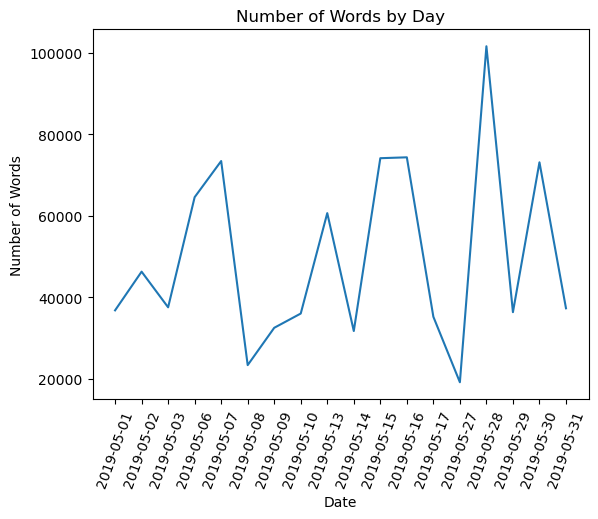

In [148]:
plt.title("Number of Words by Day")
plt.plot(num_words_by_day)
plt.ylabel("Number of Words")
plt.xlabel("Date")
plt.xticks(ticks=range(len(file_list)), labels=file_list, rotation=70)
plt.show()

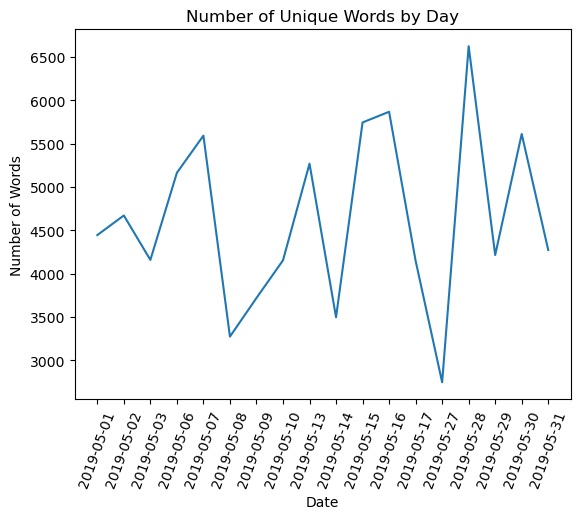

In [149]:
plt.title("Number of Unique Words by Day")
plt.plot(num_unique_words_by_day)
plt.ylabel("Number of Words")
plt.xlabel("Date")
plt.xticks(ticks=range(len(file_list)), labels=file_list, rotation=70)
plt.show()

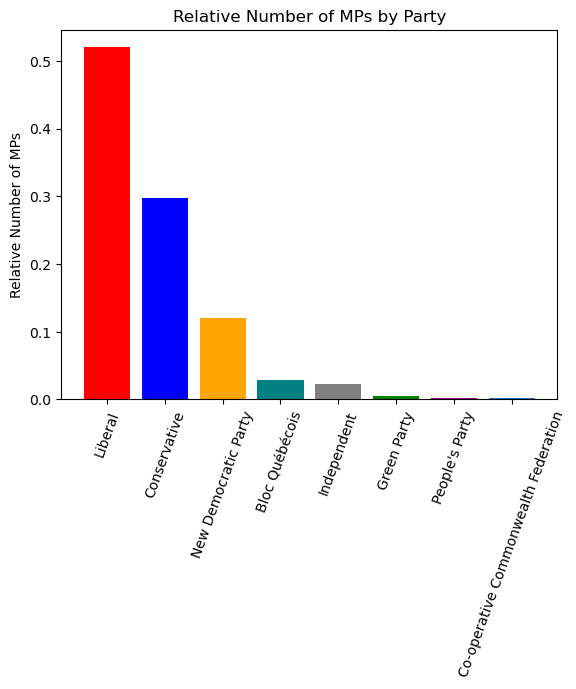

In [160]:
party_names = num_mps_by_party.index
for party in party_names:
    colour = colour_dict[party] if party in colour_dict.keys() else None
    plt.bar(party, num_mps_by_party[party]/total_num_mps, color=colour)

plt.title("Relative Number of MPs by Party")
plt.ylabel("Relative Number of MPs")
plt.xticks(ticks=range(len(party_names)), labels=party_names, rotation=70)
plt.show()

# TF.IDF

Code taken from https://towardsdatascience.com/creating-a-class-based-tf-idf-with-scikit-learn-caea7b15b858

In [179]:
aggregation_functions = {'speechtext': 'sum'}
df_party_agg = full_df.groupby(['speechdate', "speakerparty"]).aggregate(aggregation_functions).reset_index()

In [187]:
import scipy.sparse as sp

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


class CTFIDFVectorizer(TfidfTransformer):
    def __init__(self, *args, **kwargs):
        super(CTFIDFVectorizer, self).__init__(*args, **kwargs)

    def fit(self, X: sp.csr_matrix, n_samples: int):
        """Learn the idf vector (global term weights) """
        _, n_features = X.shape
        df = np.squeeze(np.asarray(X.sum(axis=0)))
        idf = np.log(n_samples / df)
        self._idf_diag = sp.diags(idf, offsets=0,
                                  shape=(n_features, n_features),
                                  format='csr',
                                  dtype=np.float64)
        return self

    def transform(self, X: sp.csr_matrix) -> sp.csr_matrix:
        """Transform a count-based matrix to c-TF-IDF """
        X = X * self._idf_diag
        X = normalize(X, axis=1, norm='l1', copy=False)
        return X

In [188]:
# Create documents per label
docs = pd.DataFrame({'Document': df_party_agg["speechtext"], 'Class': df_party_agg["speakerparty"]})
docs_per_class = docs.groupby(['Class'], as_index=False).agg({'Document': ' '.join})

# Create c-TF-IDF
count = CountVectorizer().fit_transform(docs_per_class.Document)
ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(docs))

In [213]:
# Create bag of words
count_vectorizer = CountVectorizer().fit(docs_per_class.Document)
count = count_vectorizer.transform(docs_per_class.Document)
words = count_vectorizer.get_feature_names()

# Extract top 10 words per class
ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(docs)).toarray()
words_per_class = {docs_per_class.iloc[label].Class: [words[index] for index in ctfidf[label].argsort()[-10:]]
    for label in docs_per_class.index}

In [215]:
pd.DataFrame(words_per_class)

,Bloc Québécois,Conservative,Green Party,Independent,Liberal,New Democratic Party
0,pointe,friendship,beauséjour,via,prosecute,ratify
1,assimilation,fishermen,68,inuktitut,deployed,fry
2,anglophone,disabled,gulf,guaidó,cyber,pharmacare
3,anglophones,virtue,greece,prairies,nato,cell
4,irvings,unifor,whale,itk,phasing,opioid
5,newcomers,litre,maori,abatement,doug,laundering
6,francophones,cta,seconded,stouffville,missions,automatic
7,bilingualism,huawei,nanaimo,whitby,pcrc,expunge
8,cheque,firearms,samos,kmaq,cse,havens
9,421,happiness,refinery,mi,ppsc,medication
